# Function Encoders: Learning Basis Representations for Operator Learning

**Learning Objectives:**
- Understand function representations in Hilbert space using basis functions
- Learn to compute coefficients using least squares (with derivation) and Monte Carlo integration
- Compare classical fixed bases (Fourier, polynomial, RBF) with learned neural network bases
- Implement function encoders using neural networks to learn adaptive basis functions
- Achieve orthonormality through Gram matrix regularization
- Understand basis trimming to remove redundant functions
- Apply linearity of coefficients in Hilbert space for function composition

**Exercise:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/03-function-encoder/03-function-encoder-exercise.ipynb)
**Solution:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/03-function-encoder/03-function-encoder.ipynb)

---

## Introduction

**Function encoders** represent functions in a Hilbert space as linear combinations of basis functions:

$$f(x) = \sum_{j=1}^d \alpha_j \phi_j(x)$$

**Key innovation:** Instead of using fixed basis functions (Fourier, polynomials), we **learn** the basis $\{\phi_j\}$ using neural networks to adapt to the function family.

**This notebook:**
1. Background on computing coefficients from basis functions
2. Classical fixed bases and their limitations
3. Learning basis functions with neural networks (function encoders)
4. Achieving orthonormality and basis trimming
5. Linearity of coefficients in Hilbert space

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cpu")
print(f"Device: {device}")

Device: cpu


---

## Part 1: Background - Computing Coefficients

Given basis functions $\{\phi_j(x)\}$ and a target function $f(x)$, we need to compute coefficients $\{\alpha_j\}$.

### Method 1: Least Squares (Derivation)

Given samples $\{(x_i, f(x_i))\}_{i=1}^m$, minimize reconstruction error:

$$\min_{\alpha} \sum_{i=1}^m \left( f(x_i) - \sum_{j=1}^d \alpha_j \phi_j(x_i) \right)^2$$

Define basis matrix $\Phi \in \mathbb{R}^{m \times d}$ where $\Phi_{ij} = \phi_j(x_i)$:

$$\min_{\alpha} \|\Phi \alpha - f\|_2^2$$

**Derivation:**

Taking gradient with respect to $\alpha$:

$$\nabla_{\alpha} \|\Phi \alpha - f\|_2^2 = \nabla_{\alpha} (\Phi \alpha - f)^T (\Phi \alpha - f)$$

$$= \nabla_{\alpha} (\alpha^T \Phi^T \Phi \alpha - 2f^T \Phi \alpha + f^T f)$$

$$= 2\Phi^T \Phi \alpha - 2\Phi^T f$$

Setting to zero:

$$\Phi^T \Phi \alpha = \Phi^T f$$

$$\boxed{\alpha = (\Phi^T \Phi)^{-1} \Phi^T f}$$

This is the **normal equation**.

### Method 2: Monte Carlo Integration

For orthonormal basis where $\langle \phi_i, \phi_j \rangle = \delta_{ij}$:

$$\alpha_i = \langle f, \phi_i \rangle = \int_{\mathcal{X}} f(x) \phi_i(x) \, dx$$

**Approximate with samples:**

$$\alpha_i \approx \frac{1}{N} \sum_{k=1}^N f(x_k) \phi_i(x_k) \cdot V$$

where $V = |\mathcal{X}|$ is the domain volume.

**Note:** MC integration assumes orthonormal basis. If basis is not orthonormal, LS is more accurate.

---

## Part 2: Classical Basis Functions

We compare three classical fixed bases: Fourier, Polynomial, and RBF.

**Target:** Gaussian bump family

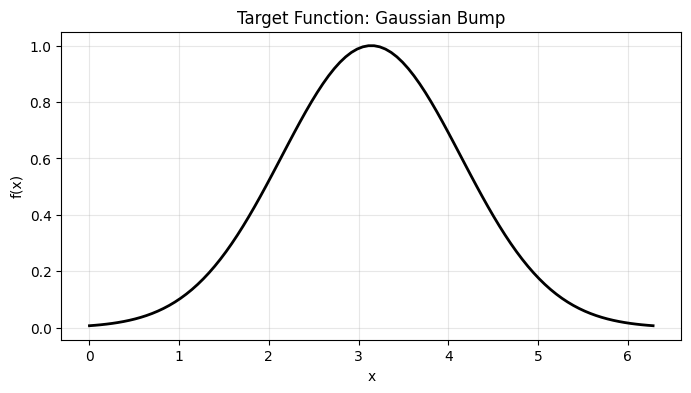

Target: Gaussian centered at π


In [21]:
# Target function family
def target_function(x, center=np.pi, width=1.0, amplitude=1.0):
    return amplitude * np.exp(-((x - center) ** 2) / (2 * width ** 2))

x = np.linspace(0, 2*np.pi, 100)
y_true = target_function(x)

plt.figure(figsize=(8, 4))
plt.plot(x, y_true, 'k-', linewidth=2)
plt.title('Target Function: Gaussian Bump')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Target: Gaussian centered at π")

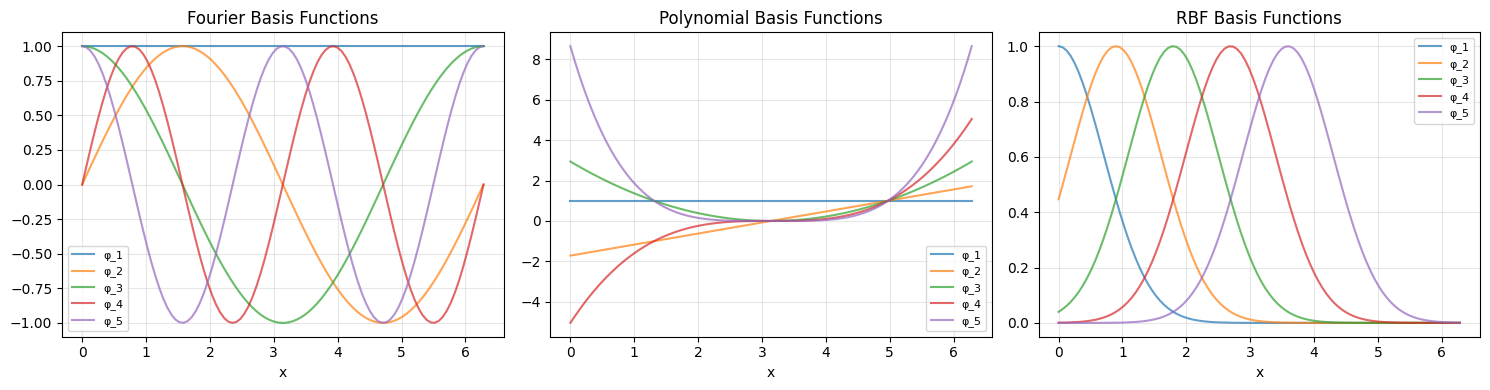

In [22]:
# Classical basis functions
def fourier_basis(x, n_basis):
    basis = [np.ones_like(x)]
    for k in range(1, n_basis//2 + 1):
        basis.append(np.sin(k * x))
        if len(basis) < n_basis:
            basis.append(np.cos(k * x))
    return np.column_stack(basis[:n_basis])

def polynomial_basis(x, n_basis):
    x_norm = (x - x.mean()) / (x.std() + 1e-8)
    return np.column_stack([x_norm**i for i in range(n_basis)])

def rbf_basis(x, n_basis, gamma=1.0):
    centers = np.linspace(x.min(), x.max(), n_basis)
    return np.exp(-gamma * (x[:, None] - centers) ** 2)

n_basis = 8

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

basis_funcs = [
    (fourier_basis(x, n_basis), 'Fourier'),
    (polynomial_basis(x, n_basis), 'Polynomial'),
    (rbf_basis(x, n_basis), 'RBF')
]

for ax, (basis, name) in zip(axes, basis_funcs):
    for i in range(min(5, n_basis)):
        ax.plot(x, basis[:, i], alpha=0.7, label=f'φ_{i+1}')
    ax.set_title(f'{name} Basis Functions')
    ax.set_xlabel('x')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Fourier      MSE: 0.000000
Polynomial   MSE: 0.000265
RBF          MSE: 0.000002


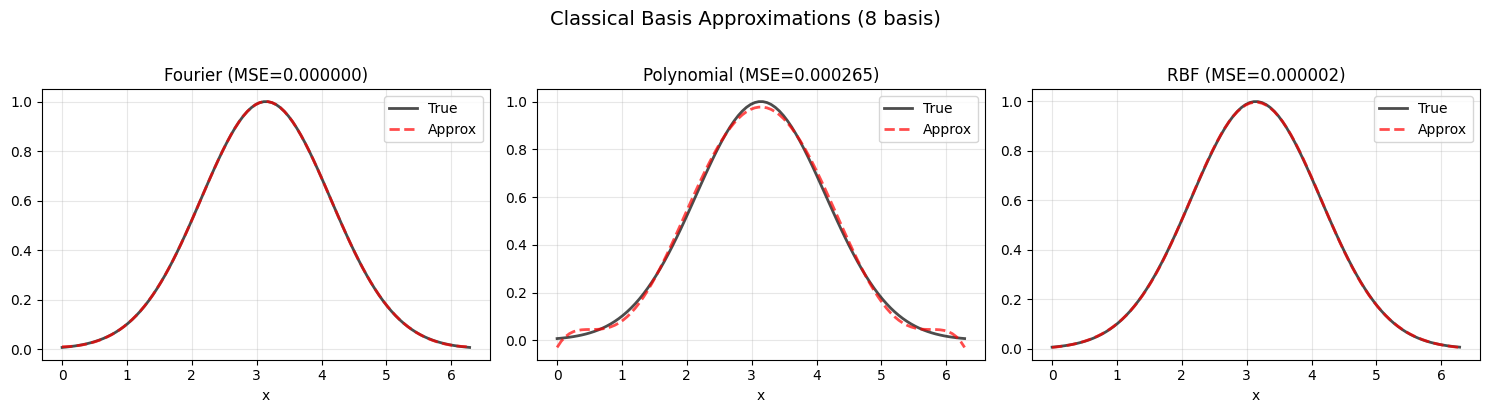

In [23]:
# Compare approximations using least squares
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (Phi, name) in zip(axes, basis_funcs):
    alpha = np.linalg.lstsq(Phi, y_true, rcond=None)[0]
    y_pred = Phi @ alpha
    mse = np.mean((y_true - y_pred) ** 2)
    
    ax.plot(x, y_true, 'k-', linewidth=2, label='True', alpha=0.7)
    ax.plot(x, y_pred, 'r--', linewidth=2, label='Approx', alpha=0.7)
    ax.set_title(f'{name} (MSE={mse:.6f})')
    ax.set_xlabel('x')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    print(f"{name:12s} MSE: {mse:.6f}")

plt.suptitle(f'Classical Basis Approximations ({n_basis} basis)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Demonstrating Least Squares vs Monte Carlo

We use RBF basis to show both methods.

In [24]:
# RBF basis for detailed comparison
n_rbf = 10
x_fine = np.linspace(0, 2*np.pi, 200)
Phi_rbf = rbf_basis(x_fine, n_rbf, gamma=2.0)
f_target = target_function(x_fine, center=np.pi, width=0.8)

# Manual least squares calculation (showing the derivation)
print("Manual Least Squares Calculation:")
print("="*60)
PhiT = Phi_rbf.T
PhiT_Phi = PhiT @ Phi_rbf
print(f"Φ^T Φ shape: {PhiT_Phi.shape}")
PhiT_f = PhiT @ f_target
print(f"Φ^T f shape: {PhiT_f.shape}")
alpha_ls_manual = np.linalg.solve(PhiT_Phi, PhiT_f)
print(f"α = (Φ^T Φ)^-1 Φ^T f computed")
f_recon_ls = Phi_rbf @ alpha_ls_manual
mse_ls = np.mean((f_target - f_recon_ls) ** 2)
print(f"LS MSE: {mse_ls:.8f}\n")

# Monte Carlo integration
print("Monte Carlo Integration:")
print("="*60)
dx = x_fine[1] - x_fine[0]
V = x_fine[-1] - x_fine[0]
# MC: α_i = <f, φ_i> ≈ (1/N) Σ f(x_k)φ_i(x_k) * V
alpha_mc = (V / len(x_fine)) * np.sum(f_target[:, None] * Phi_rbf, axis=0)
f_recon_mc = Phi_rbf @ alpha_mc
mse_mc = np.mean((f_target - f_recon_mc) ** 2)
print(f"MC MSE: {mse_mc:.8f}\n")

# Check Gram matrix
G_rbf = Phi_rbf.T @ Phi_rbf * dx
ortho_error = np.linalg.norm(G_rbf - np.eye(n_rbf), 'fro')
print(f"Gram matrix orthonormality error: {ortho_error:.4f}")
print(f"Conclusion: RBF basis is NOT orthonormal, so LS is more accurate")

Manual Least Squares Calculation:
Φ^T Φ shape: (10, 10)
Φ^T f shape: (10,)
α = (Φ^T Φ)^-1 Φ^T f computed
LS MSE: 0.00000193

Monte Carlo Integration:
MC MSE: 0.21518306

Gram matrix orthonormality error: 2.4396
Conclusion: RBF basis is NOT orthonormal, so LS is more accurate


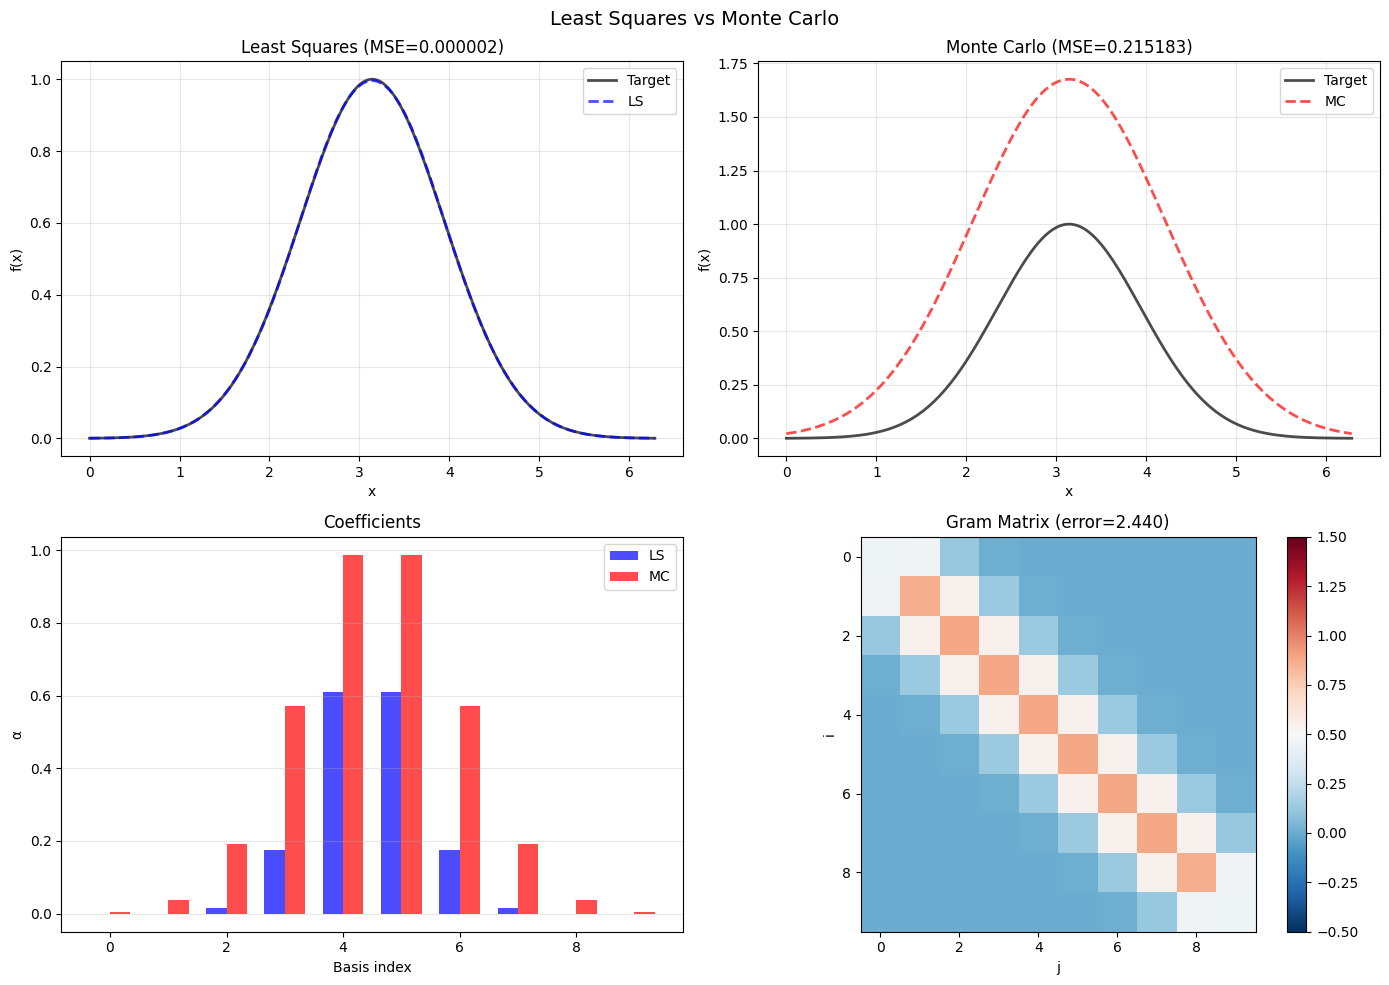

In [25]:
# Visualize LS vs MC
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
ax.plot(x_fine, f_target, 'k-', linewidth=2, label='Target', alpha=0.7)
ax.plot(x_fine, f_recon_ls, 'b--', linewidth=2, label='LS', alpha=0.7)
ax.set_title(f'Least Squares (MSE={mse_ls:.6f})')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(x_fine, f_target, 'k-', linewidth=2, label='Target', alpha=0.7)
ax.plot(x_fine, f_recon_mc, 'r--', linewidth=2, label='MC', alpha=0.7)
ax.set_title(f'Monte Carlo (MSE={mse_mc:.6f})')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
idx = np.arange(n_rbf)
width = 0.35
ax.bar(idx - width/2, alpha_ls_manual, width, label='LS', alpha=0.7, color='blue')
ax.bar(idx + width/2, alpha_mc, width, label='MC', alpha=0.7, color='red')
ax.set_title('Coefficients')
ax.set_xlabel('Basis index')
ax.set_ylabel('α')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

ax = axes[1, 1]
im = ax.imshow(G_rbf, cmap='RdBu_r', vmin=-0.5, vmax=1.5)
ax.set_title(f'Gram Matrix (error={ortho_error:.3f})')
ax.set_xlabel('j')
ax.set_ylabel('i')
plt.colorbar(im, ax=ax)

plt.suptitle('Least Squares vs Monte Carlo', fontsize=14)
plt.tight_layout()
plt.show()

**Observation:** RBF basis is not orthonormal (Gram matrix $\neq I$), so least squares gives better reconstruction than Monte Carlo integration.

---

## Part 3: Learning Basis Functions (Function Encoders)

**Key idea:** Use neural networks to **learn** basis functions $\{\phi_j(x; \theta_j)\}$ adapted to the function family.

### Architecture 1: Single MLP

One network outputs all basis functions: $\phi(x; \theta): \mathbb{R} \to \mathbb{R}^d$

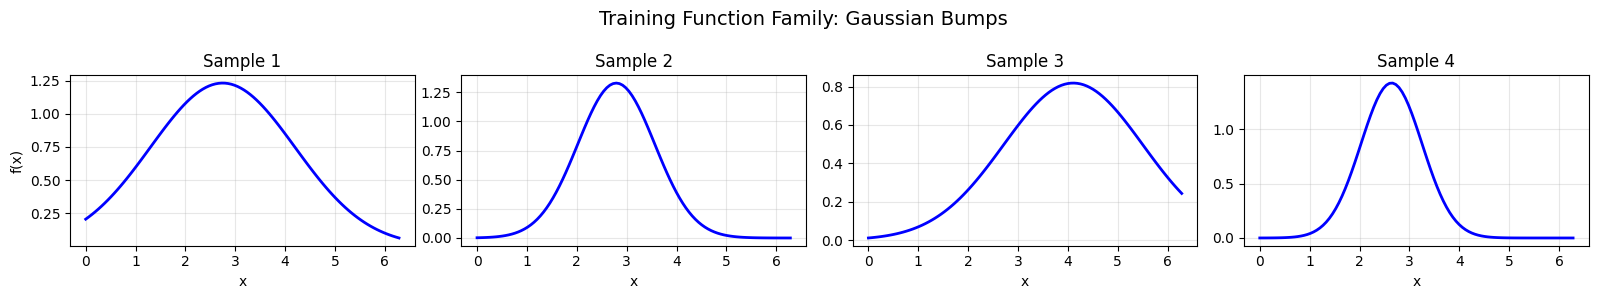

Dataset: 500 train, 100 test functions


In [26]:
# Create dataset: family of Gaussian bumps
def create_function_dataset(n_samples=500, n_points=100):
    x_data = np.linspace(0, 2*np.pi, n_points)
    functions = []
    
    for _ in range(n_samples):
        center = np.random.uniform(np.pi/2, 3*np.pi/2)
        width = np.random.uniform(0.5, 1.5)
        amplitude = np.random.uniform(0.5, 1.5)
        y = target_function(x_data, center, width, amplitude)
        functions.append(y)
    
    return x_data, np.array(functions)

x_train, f_train = create_function_dataset(n_samples=500)
x_test, f_test = create_function_dataset(n_samples=100)

x_torch = torch.FloatTensor(x_train)
f_torch = torch.FloatTensor(f_train)
x_test_torch = torch.FloatTensor(x_test)
f_test_torch = torch.FloatTensor(f_test)

# Visualize dataset
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
for i, ax in enumerate(axes):
    ax.plot(x_train, f_train[i*20], 'b-', linewidth=2)
    ax.set_title(f'Sample {i+1}')
    ax.set_xlabel('x')
    ax.grid(True, alpha=0.3)
axes[0].set_ylabel('f(x)')
plt.suptitle('Training Function Family: Gaussian Bumps', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Dataset: {len(f_train)} train, {len(f_test)} test functions")

In [ ]:
class SingleMLPBasis(nn.Module):
    def __init__(self, n_basis, hidden=64):
        super().__init__()
        self.n_basis = n_basis
        # TODO: Define network architecture
        # Hint: Input dim = 1, output dim = n_basis
        # Use hidden layers with Tanh activation
        
        
        
        
        
        
        
        self.net = None  # Your code here
    
    def forward(self, x):
        # TODO: Implement forward pass
        # Hint: Handle 1D input by adding dimension if needed
        
        
        
        
        
        
        pass  # Your code here

def train_function_encoder(model, x, f, n_epochs=200, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    
    for epoch in tqdm(range(n_epochs), desc="Training"):
        model.train()
        # TODO: Get basis functions Phi from model
        
        
        
        Phi = None  # Your code here
        
        # TODO: Solve for coefficients using least squares
        # Hint: α = (Φ^T Φ)^-1 Φ^T f
        # Use torch.linalg.solve for numerical stability
        
        
        
        
        
        
        PhiT_Phi = None  # Your code here
        PhiT_f = None  # Your code here
        alpha = None  # Your code here
        
        # TODO: Reconstruct functions and compute MSE loss
        
        
        
        
        
        f_pred = None  # Your code here
        loss = None  # Your code here
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    return losses

model_single = SingleMLPBasis(n_basis=8)
losses_single = train_function_encoder(model_single, x_torch, f_torch)

plt.figure(figsize=(8, 4))
plt.plot(losses_single)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Single MLP Training')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {losses_single[-1]:.6f}")

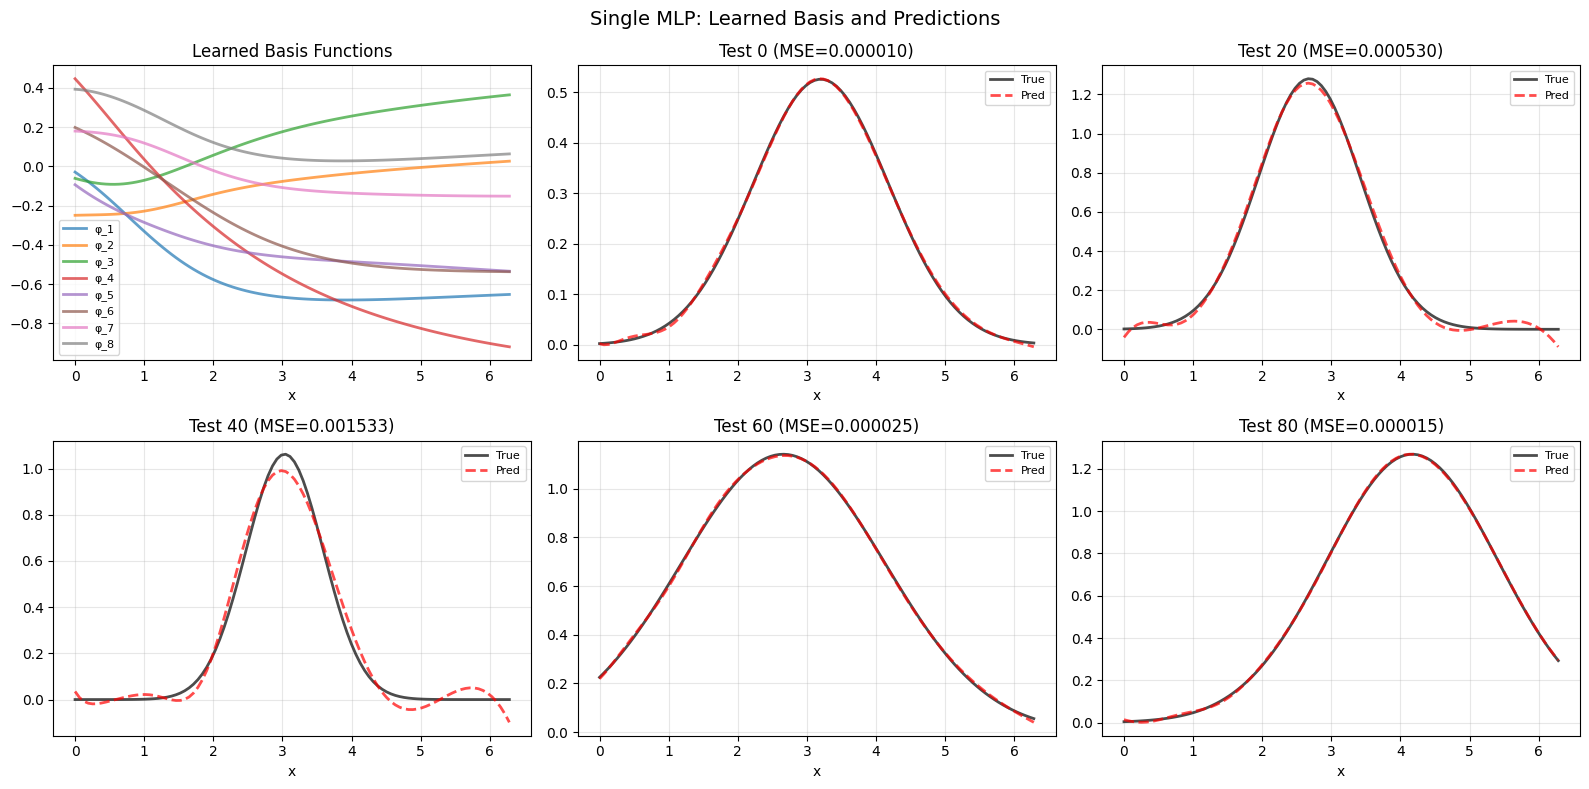

In [28]:
# Visualize learned basis and predictions
model_single.eval()
with torch.no_grad():
    Phi_learned = model_single(x_torch).numpy()

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Basis functions
ax = axes[0, 0]
for i in range(model_single.n_basis):
    ax.plot(x_train, Phi_learned[:, i], alpha=0.7, linewidth=2, label=f'φ_{i+1}')
ax.set_title('Learned Basis Functions')
ax.set_xlabel('x')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Test predictions
test_indices = [0, 20, 40, 60, 80]
for col, idx in enumerate(test_indices[:5]):
    if col < 2:
        ax = axes[0, col+1]
    else:
        ax = axes[1, col-2]
    
    with torch.no_grad():
        Phi_test = model_single(x_test_torch)
        PhiT_Phi = Phi_test.T @ Phi_test
        PhiT_f = Phi_test.T @ f_test_torch[idx]
        alpha = torch.linalg.solve(PhiT_Phi, PhiT_f)
        f_recon = (Phi_test @ alpha).numpy()
    
    mse = np.mean((f_test[idx] - f_recon) ** 2)
    ax.plot(x_test, f_test[idx], 'k-', linewidth=2, label='True', alpha=0.7)
    ax.plot(x_test, f_recon, 'r--', linewidth=2, label='Pred', alpha=0.7)
    ax.set_title(f'Test {idx} (MSE={mse:.6f})')
    ax.set_xlabel('x')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Single MLP: Learned Basis and Predictions', fontsize=14)
plt.tight_layout()
plt.show()

### Architecture 2: Separate MLPs

Each basis function is a separate network: $\phi_j(x; \theta_j): \mathbb{R} \to \mathbb{R}$

In [ ]:
class SeparateMLPBasis(nn.Module):
    def __init__(self, n_basis, hidden=32):
        super().__init__()
        self.n_basis = n_basis
        # TODO: Create n_basis separate neural networks
        # Hint: Each network maps R -> R (input dim=1, output dim=1)
        # Use nn.ModuleList to store multiple networks
        
        
        
        
        
        
        
        
        
        
        self.networks = None  # Your code here
    
    def forward(self, x):
        # TODO: Implement forward pass
        # Hint: Apply each network and concatenate outputs
        # Handle 1D input by adding dimension if needed
        
        
        
        
        
        
        
        pass  # Your code here

model_separate = SeparateMLPBasis(n_basis=8)
losses_separate = train_function_encoder(model_separate, x_torch, f_torch, n_epochs=200)

plt.figure(figsize=(8, 4))
plt.plot(losses_separate)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Separate MLPs Training')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {losses_separate[-1]:.6f}")

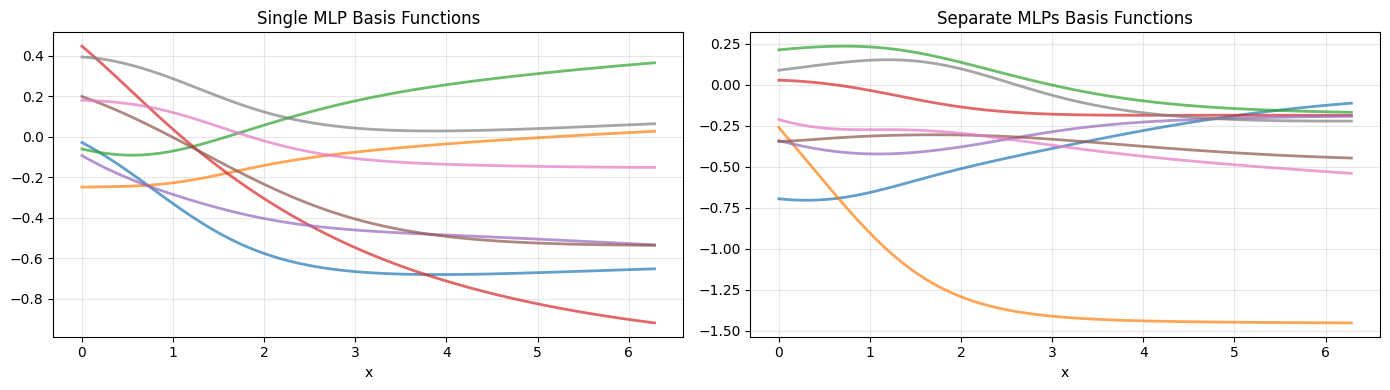

Single MLP   - Params: 4,808
Separate MLP - Params: 9,224


In [30]:
# Compare architectures
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, model, name in [(axes[0], model_single, 'Single MLP'),
                         (axes[1], model_separate, 'Separate MLPs')]:
    model.eval()
    with torch.no_grad():
        Phi = model(x_torch).numpy()
    
    for i in range(model.n_basis):
        ax.plot(x_train, Phi[:, i], alpha=0.7, linewidth=2)
    ax.set_title(f'{name} Basis Functions')
    ax.set_xlabel('x')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Single MLP   - Params: {sum(p.numel() for p in model_single.parameters()):,}")
print(f"Separate MLP - Params: {sum(p.numel() for p in model_separate.parameters()):,}")

---

## Part 4: Achieving Orthonormality via Gram Matrix

The **Gram matrix** measures orthonormality:

$$G_{ij} = \langle \phi_i, \phi_j \rangle = \int \phi_i(x) \phi_j(x) dx \approx \sum_k \phi_i(x_k) \phi_j(x_k) \Delta x$$

**Ideal:** $G = I$ (orthonormal basis)

Analyzing Separate MLPs (before orthonormalization):


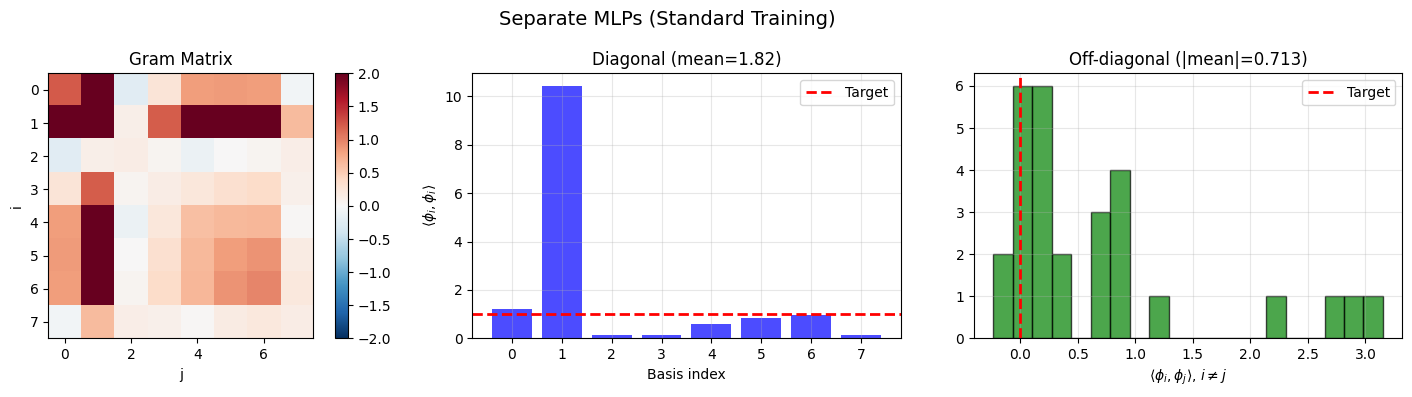

Orthonormality deviation: 12.8401
Diagonal: 1.816 ± 3.276
Off-diagonal: 0.7126


In [31]:
def compute_gram_matrix(model, x):
    model.eval()
    with torch.no_grad():
        Phi = model(x).numpy()
    dx = (x[-1] - x[0]) / (len(x) - 1)
    G = Phi.T @ Phi * dx.item()
    return G

def plot_gram_analysis(model, x, title):
    G = compute_gram_matrix(model, x)
    n = G.shape[0]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    ax = axes[0]
    im = ax.imshow(G, cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('Gram Matrix')
    ax.set_xlabel('j')
    ax.set_ylabel('i')
    plt.colorbar(im, ax=ax)
    
    ax = axes[1]
    diag = np.diag(G)
    ax.bar(range(n), diag, alpha=0.7, color='blue')
    ax.axhline(1.0, color='red', linestyle='--', linewidth=2, label='Target')
    ax.set_title(f'Diagonal (mean={diag.mean():.2f})')
    ax.set_xlabel('Basis index')
    ax.set_ylabel(r'$\langle \phi_i, \phi_i \rangle$')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[2]
    off_diag = G[np.triu_indices(n, k=1)]
    if len(off_diag) > 0:
        ax.hist(off_diag, bins=20, alpha=0.7, edgecolor='black', color='green')
        ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Target')
        ax.set_title(f'Off-diagonal (|mean|={np.abs(off_diag).mean():.3f})')
        ax.set_xlabel(r'$\langle \phi_i, \phi_j \rangle$, $i \neq j$')
        ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    ortho_score = np.linalg.norm(G - np.eye(n), 'fro')
    print(f"Orthonormality deviation: {ortho_score:.4f}")
    print(f"Diagonal: {diag.mean():.3f} ± {diag.std():.3f}")
    if len(off_diag) > 0:
        print(f"Off-diagonal: {np.abs(off_diag).mean():.4f}")

print("Analyzing Separate MLPs (before orthonormalization):")
plot_gram_analysis(model_separate, x_torch, "Separate MLPs (Standard Training)")

### Two-Stage Training for Orthonormality

**Stage 1:** Train with Gram loss  
$$\mathcal{L} = \mathcal{L}_{\text{recon}} + \lambda \|G - I\|_F^2$$

**Stage 2:** Fine-tune with reconstruction only

Stage 1: Training with Gram loss


100%|██████████| 150/150 [00:00<00:00, 214.10it/s]


Stage 2: Fine-tuning without Gram loss


100%|██████████| 50/50 [00:00<00:00, 314.86it/s]


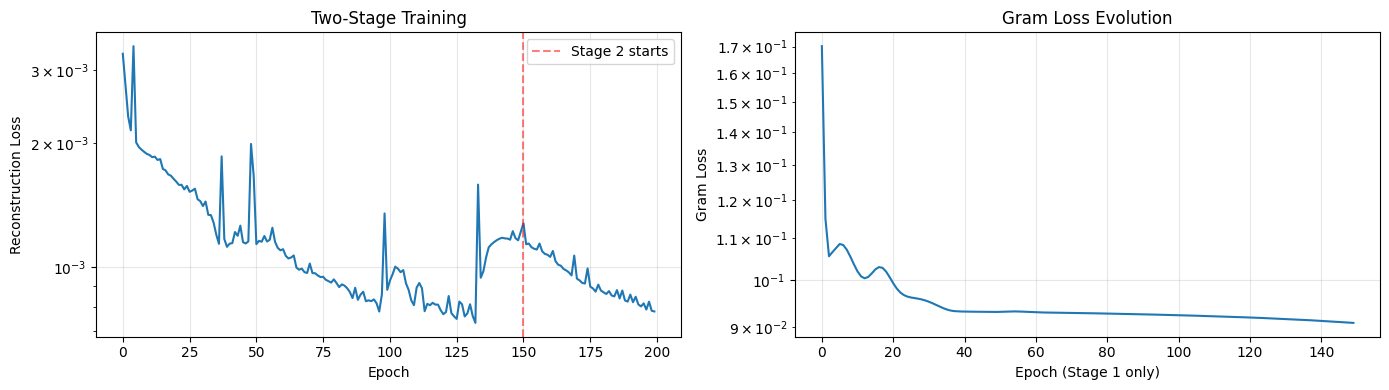

Final reconstruction loss: 0.000782
Final Gram loss: 0.090812


In [32]:
def gram_loss(model, x):
    Phi = model(x)
    dx = (x[-1] - x[0]) / (len(x) - 1)
    G = Phi.T @ Phi * dx
    I = torch.eye(model.n_basis)
    return torch.mean((G - I) ** 2)

def train_two_stage(model, x, f, lambda_gram=1.0, n_epochs_s1=150, n_epochs_s2=50, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses_recon = []
    losses_gram = []
    
    print("Stage 1: Training with Gram loss")
    for epoch in tqdm(range(n_epochs_s1)):
        model.train()
        Phi = model(x)
        PhiT_Phi = Phi.T @ Phi
        PhiT_f = Phi.T @ f.T
        alpha = torch.linalg.solve(PhiT_Phi, PhiT_f)
        f_pred = Phi @ alpha
        loss_recon = torch.mean((f.T - f_pred) ** 2)
        loss_g = gram_loss(model, x)
        loss = loss_recon + lambda_gram * loss_g
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses_recon.append(loss_recon.item())
        losses_gram.append(loss_g.item())
    
    print("Stage 2: Fine-tuning without Gram loss")
    for epoch in tqdm(range(n_epochs_s2)):
        model.train()
        Phi = model(x)
        PhiT_Phi = Phi.T @ Phi
        PhiT_f = Phi.T @ f.T
        alpha = torch.linalg.solve(PhiT_Phi, PhiT_f)
        f_pred = Phi @ alpha
        loss = torch.mean((f.T - f_pred) ** 2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses_recon.append(loss.item())
    
    return losses_recon, losses_gram

model_ortho = SeparateMLPBasis(n_basis=8)
losses_recon, losses_gram = train_two_stage(model_ortho, x_torch, f_torch, lambda_gram=0.5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.plot(losses_recon)
ax1.axvline(150, color='red', linestyle='--', alpha=0.5, label='Stage 2 starts')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Reconstruction Loss')
ax1.set_title('Two-Stage Training')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(losses_gram)
ax2.set_xlabel('Epoch (Stage 1 only)')
ax2.set_ylabel('Gram Loss')
ax2.set_title('Gram Loss Evolution')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final reconstruction loss: {losses_recon[-1]:.6f}")
print(f"Final Gram loss: {losses_gram[-1]:.6f}")


WITHOUT Orthonormalization:


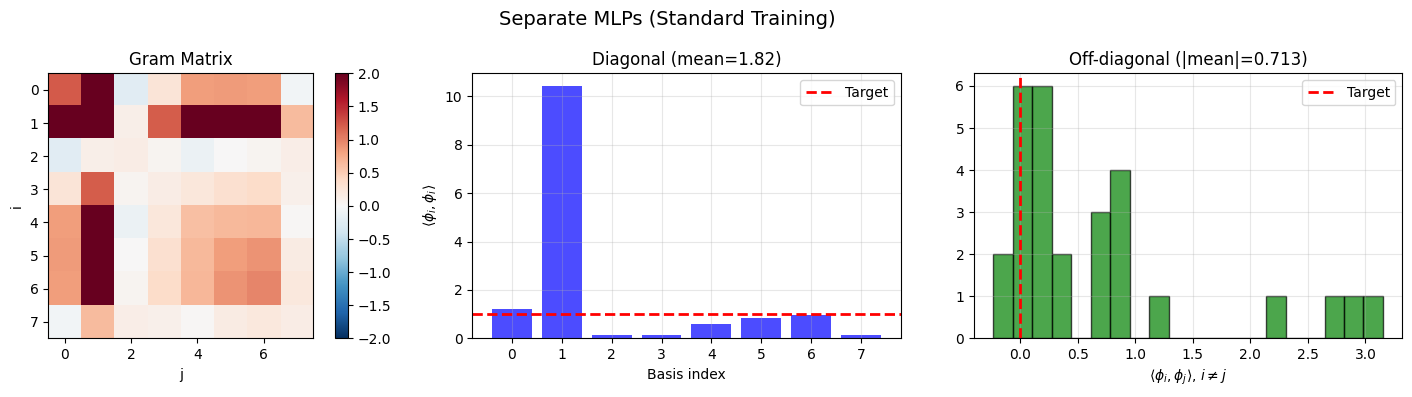

Orthonormality deviation: 12.8401
Diagonal: 1.816 ± 3.276
Off-diagonal: 0.7126

WITH Orthonormalization (Two-Stage):


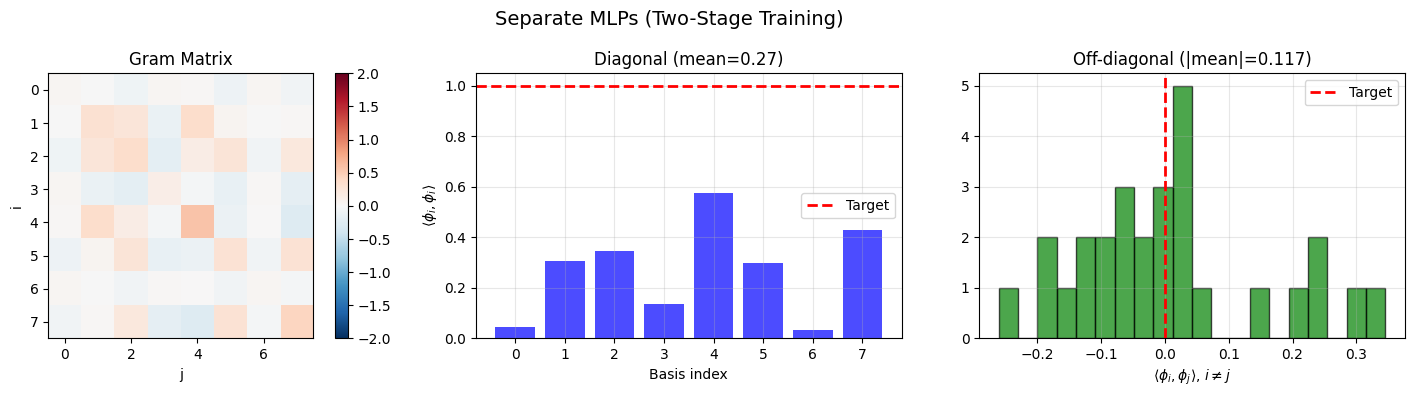

Orthonormality deviation: 2.4059
Diagonal: 0.271 ± 0.177
Off-diagonal: 0.1169


In [33]:
# Compare orthonormality
print("\n" + "="*60)
print("WITHOUT Orthonormalization:")
print("="*60)
plot_gram_analysis(model_separate, x_torch, "Separate MLPs (Standard Training)")

print("\n" + "="*60)
print("WITH Orthonormalization (Two-Stage):")
print("="*60)
plot_gram_analysis(model_ortho, x_torch, "Separate MLPs (Two-Stage Training)")

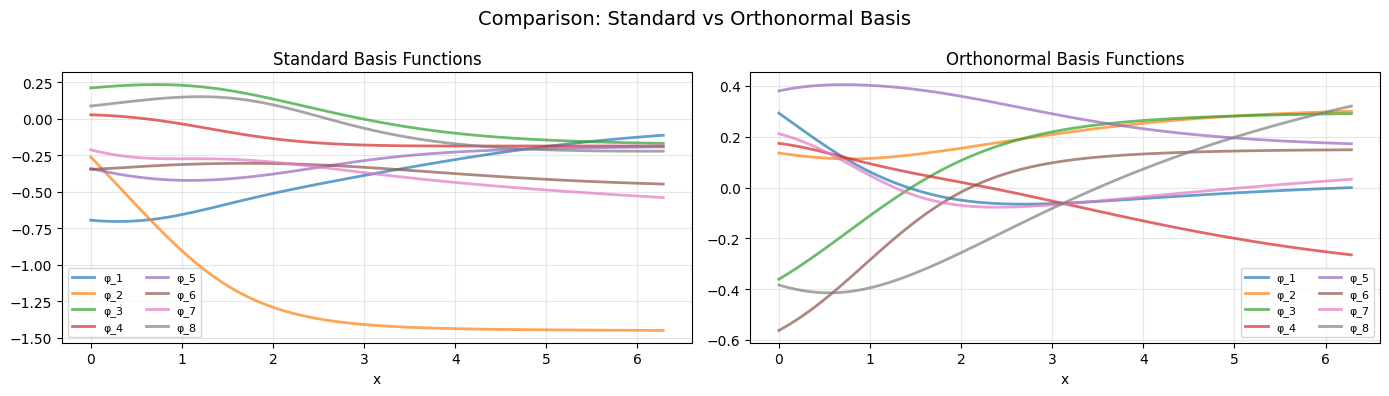

In [34]:
# Compare predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, model, title in [(axes[0], model_separate, 'Standard'),
                          (axes[1], model_ortho, 'Orthonormal')]:
    model.eval()
    with torch.no_grad():
        Phi = model(x_torch).numpy()
    
    for i in range(model.n_basis):
        ax.plot(x_train, Phi[:, i], alpha=0.7, linewidth=2, label=f'φ_{i+1}')
    ax.set_title(f'{title} Basis Functions')
    ax.set_xlabel('x')
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)

plt.suptitle('Comparison: Standard vs Orthonormal Basis', fontsize=14)
plt.tight_layout()
plt.show()

---

## Part 5: Basis Trimming

Use Gram matrix analysis to identify and remove redundant basis functions.

**Strategy:** Trim basis functions to 4 (similar to DeepSets_DeepONet.ipynb example).

In [35]:
def analyze_and_trim_basis(model, x, target_n_basis=4):
    """Trim basis to target number based on Gram matrix quality"""
    G = compute_gram_matrix(model, x)
    n = G.shape[0]
    diag = np.diag(G)
    
    # Score each basis: higher score = better quality
    scores = []
    for i in range(n):
        norm_score = 1.0 - abs(diag[i] - 1.0)
        off_diag_vals = [abs(G[i, j]) for j in range(n) if j != i]
        ortho_score = 1.0 - (max(off_diag_vals) if off_diag_vals else 0)
        scores.append(norm_score + ortho_score)
    
    # Keep top target_n_basis
    keep_indices = np.argsort(scores)[-target_n_basis:]
    keep_indices = sorted(keep_indices)
    
    print(f"Trimming from {n} to {target_n_basis} basis functions")
    print(f"Keeping indices: {keep_indices}")
    print(f"Quality scores: {[f'{scores[i]:.3f}' for i in keep_indices]}")
    
    # Create trimmed model
    model_trimmed = SeparateMLPBasis(n_basis=target_n_basis)
    for new_idx, old_idx in enumerate(keep_indices):
        model_trimmed.networks[new_idx].load_state_dict(
            model.networks[old_idx].state_dict()
        )
    
    return model_trimmed, keep_indices

# Trim standard model to 4 basis
model_trimmed, keep_indices = analyze_and_trim_basis(model_separate, x_torch, target_n_basis=4)

Trimming from 8 to 4 basis functions
Keeping indices: [np.int64(2), np.int64(3), np.int64(4), np.int64(7)]
Quality scores: ['0.919', '-0.061', '-0.598', '0.530']


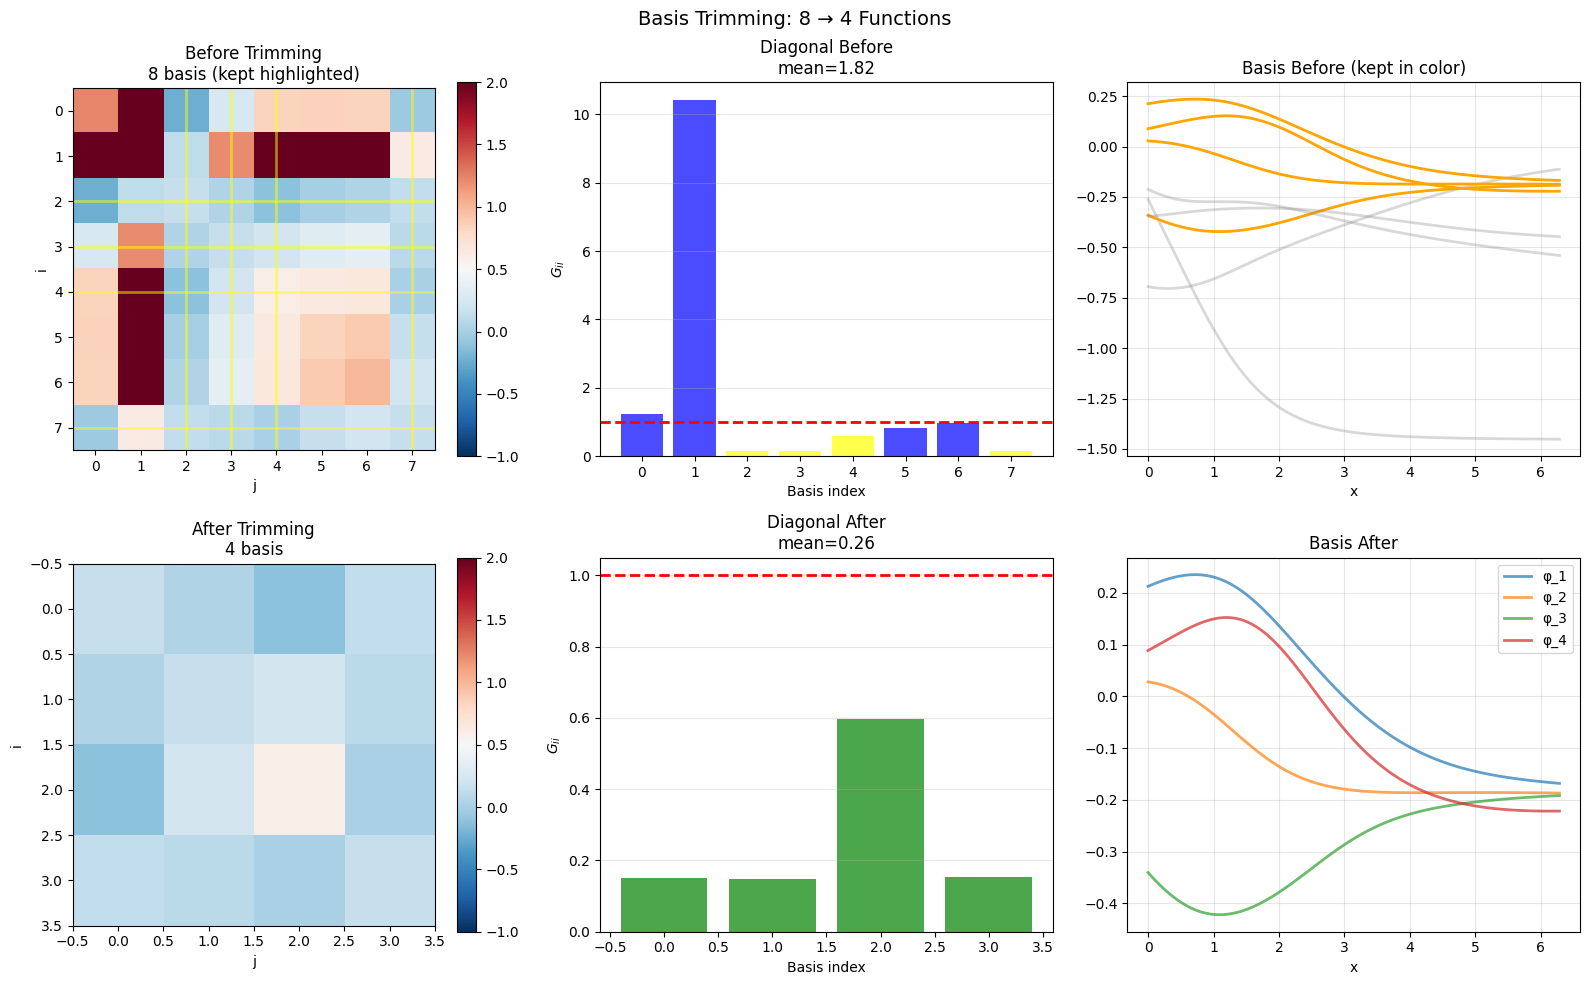

Orthonormality score before: 12.8401
Orthonormality score after: 1.5837
Improvement: 87.7%


In [36]:
# Compare before and after trimming
G_before = compute_gram_matrix(model_separate, x_torch)
G_after = compute_gram_matrix(model_trimmed, x_torch)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Gram matrices
ax = axes[0, 0]
im = ax.imshow(G_before, cmap='RdBu_r', vmin=-1, vmax=2)
for idx in keep_indices:
    ax.axhline(idx, color='yellow', linewidth=2, alpha=0.5)
    ax.axvline(idx, color='yellow', linewidth=2, alpha=0.5)
ax.set_title(f'Before Trimming\n{model_separate.n_basis} basis (kept highlighted)')
ax.set_xlabel('j')
ax.set_ylabel('i')
plt.colorbar(im, ax=ax)

ax = axes[1, 0]
im = ax.imshow(G_after, cmap='RdBu_r', vmin=-1, vmax=2)
ax.set_title(f'After Trimming\n{model_trimmed.n_basis} basis')
ax.set_xlabel('j')
ax.set_ylabel('i')
plt.colorbar(im, ax=ax)

# Diagonals
ax = axes[0, 1]
diag_before = np.diag(G_before)
colors = ['yellow' if i in keep_indices else 'blue' for i in range(len(diag_before))]
ax.bar(range(len(diag_before)), diag_before, alpha=0.7, color=colors)
ax.axhline(1.0, color='red', linestyle='--', linewidth=2)
ax.set_title(f'Diagonal Before\nmean={diag_before.mean():.2f}')
ax.set_xlabel('Basis index')
ax.set_ylabel('$G_{ii}$')
ax.grid(True, alpha=0.3, axis='y')

ax = axes[1, 1]
diag_after = np.diag(G_after)
ax.bar(range(len(diag_after)), diag_after, alpha=0.7, color='green')
ax.axhline(1.0, color='red', linestyle='--', linewidth=2)
ax.set_title(f'Diagonal After\nmean={diag_after.mean():.2f}')
ax.set_xlabel('Basis index')
ax.set_ylabel('$G_{ii}$')
ax.grid(True, alpha=0.3, axis='y')

# Basis functions
ax = axes[0, 2]
model_separate.eval()
with torch.no_grad():
    Phi_before = model_separate(x_torch).numpy()
for i in range(model_separate.n_basis):
    color = 'orange' if i in keep_indices else 'gray'
    alpha_val = 1.0 if i in keep_indices else 0.3
    ax.plot(x_train, Phi_before[:, i], alpha=alpha_val, linewidth=2, color=color)
ax.set_title('Basis Before (kept in color)')
ax.set_xlabel('x')
ax.grid(True, alpha=0.3)

ax = axes[1, 2]
model_trimmed.eval()
with torch.no_grad():
    Phi_after = model_trimmed(x_torch).numpy()
for i in range(model_trimmed.n_basis):
    ax.plot(x_train, Phi_after[:, i], alpha=0.7, linewidth=2, label=f'φ_{i+1}')
ax.set_title('Basis After')
ax.set_xlabel('x')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Basis Trimming: 8 → 4 Functions', fontsize=14)
plt.tight_layout()
plt.show()

ortho_before = np.linalg.norm(G_before - np.eye(model_separate.n_basis), 'fro')
ortho_after = np.linalg.norm(G_after - np.eye(model_trimmed.n_basis), 'fro')
print(f"Orthonormality score before: {ortho_before:.4f}")
print(f"Orthonormality score after: {ortho_after:.4f}")
print(f"Improvement: {((ortho_before - ortho_after) / ortho_before * 100):.1f}%")

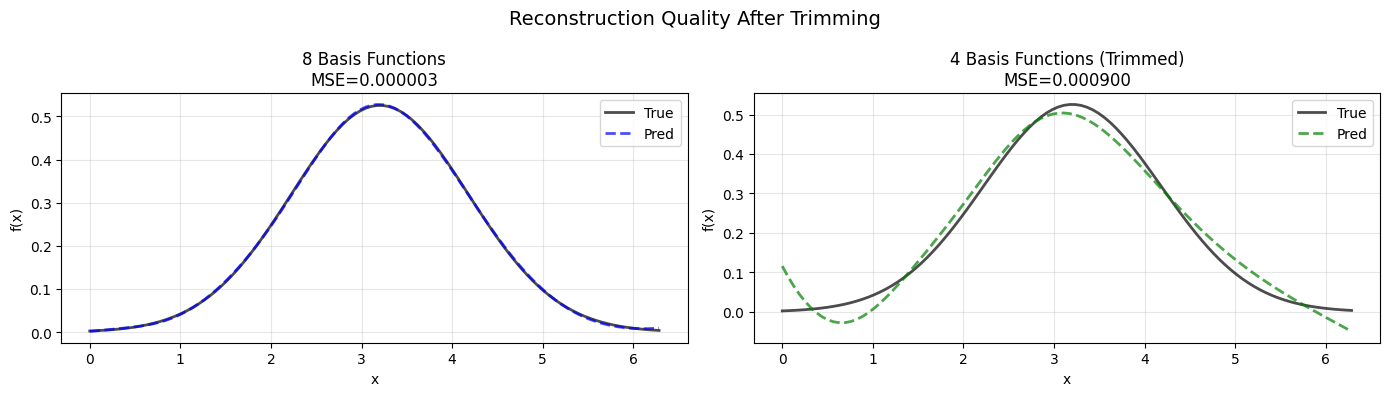


Reconstruction MSE:
  8 basis: 0.00000299
  4 basis: 0.00090001
Trimming maintains good approximation quality with fewer basis!


In [37]:
# Test reconstruction quality
test_idx = 0

model_separate.eval()
model_trimmed.eval()

with torch.no_grad():
    Phi_before = model_separate(x_test_torch)
    PhiT_Phi = Phi_before.T @ Phi_before
    PhiT_f = Phi_before.T @ f_test_torch[test_idx]
    alpha_before = torch.linalg.solve(PhiT_Phi, PhiT_f)
    f_recon_before = (Phi_before @ alpha_before).numpy()
    
    Phi_after = model_trimmed(x_test_torch)
    PhiT_Phi = Phi_after.T @ Phi_after
    PhiT_f = Phi_after.T @ f_test_torch[test_idx]
    alpha_after = torch.linalg.solve(PhiT_Phi, PhiT_f)
    f_recon_after = (Phi_after @ alpha_after).numpy()

mse_before = np.mean((f_test[test_idx] - f_recon_before) ** 2)
mse_after = np.mean((f_test[test_idx] - f_recon_after) ** 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(x_test, f_test[test_idx], 'k-', linewidth=2, label='True', alpha=0.7)
ax1.plot(x_test, f_recon_before, 'b--', linewidth=2, label='Pred', alpha=0.7)
ax1.set_title(f'8 Basis Functions\nMSE={mse_before:.6f}')
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(x_test, f_test[test_idx], 'k-', linewidth=2, label='True', alpha=0.7)
ax2.plot(x_test, f_recon_after, 'g--', linewidth=2, label='Pred', alpha=0.7)
ax2.set_title(f'4 Basis Functions (Trimmed)\nMSE={mse_after:.6f}')
ax2.set_xlabel('x')
ax2.set_ylabel('f(x)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Reconstruction Quality After Trimming', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nReconstruction MSE:")
print(f"  8 basis: {mse_before:.8f}")
print(f"  4 basis: {mse_after:.8f}")
print(f"Trimming maintains good approximation quality with fewer basis!")

---

## Part 6: Linearity of Coefficients in Hilbert Space

**Key property:** In a Hilbert space with basis $\{\phi_j\}$, coefficients preserve linear structure.

For functions $f_1, f_2 \in \mathcal{H}$ with coefficients $\alpha^{(1)}, \alpha^{(2)}$:

$$f_1(x) = \sum_j \alpha_j^{(1)} \phi_j(x), \quad f_2(x) = \sum_j \alpha_j^{(2)} \phi_j(x)$$

**Linear combination:**

$$f_3 = a f_1 + b f_2 \quad \Rightarrow \quad \alpha^{(3)} = a \alpha^{(1)} + b \alpha^{(2)}$$

This enables **composition** of functions in coefficient space without recomputing basis.

**Application:** Transfer learning, function interpolation, operator learning.

Linearity of Coefficients in Hilbert Space
f₃ = 0.5f₁ + 0.5f₂       : MSE = 0.00001040
f₃ = 0.7f₁ + 0.3f₂       : MSE = 0.00008085
f₃ = f₁ - 0.5f₂          : MSE = 0.00145489
f₃ = 2f₁ + f₂            : MSE = 0.00048657


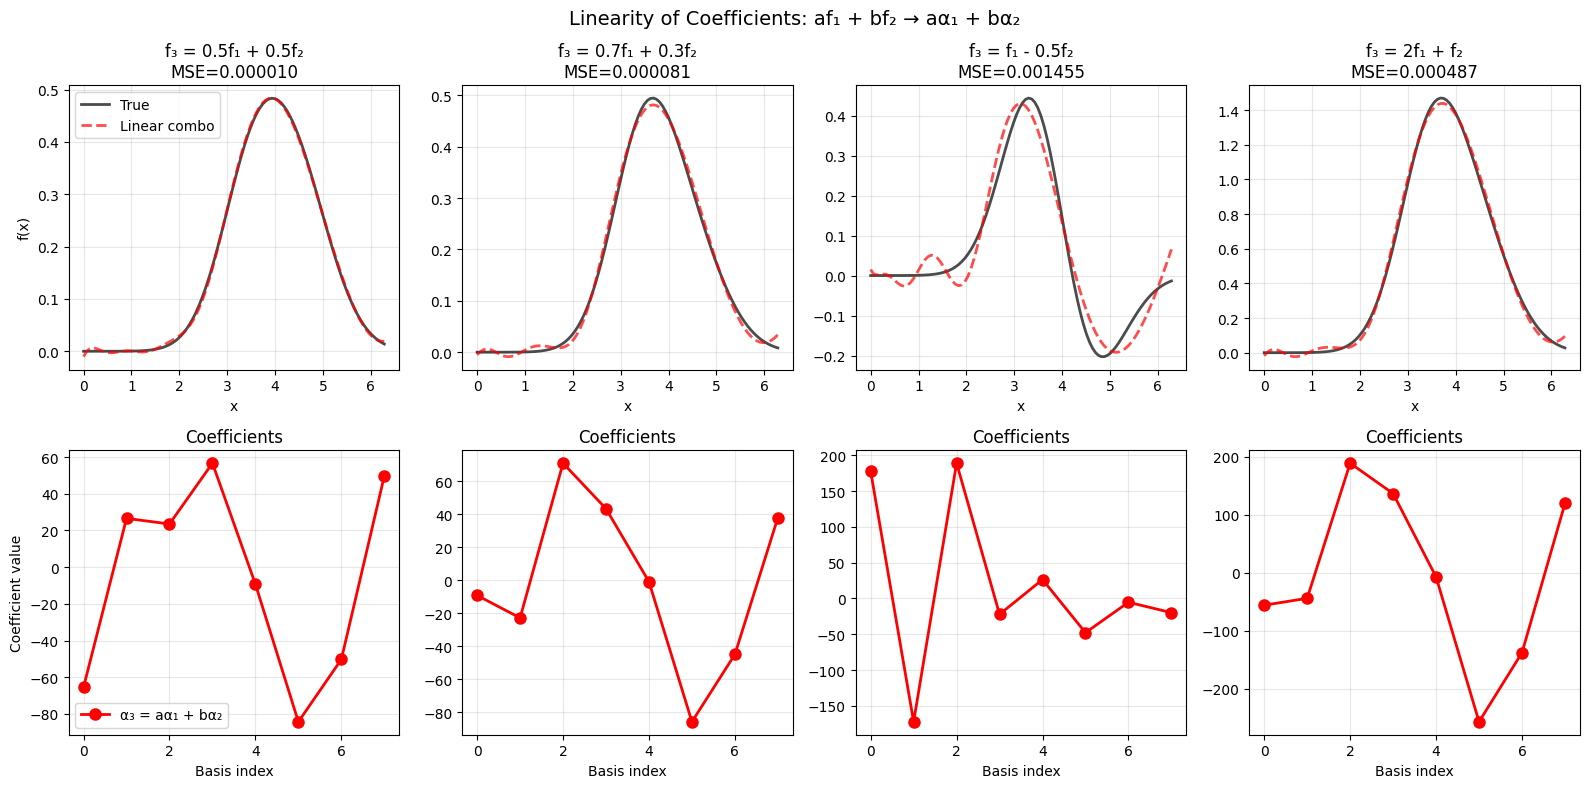


Linear structure in coefficient space enables function composition!


In [38]:
# Demonstrate linearity of coefficients
print("Linearity of Coefficients in Hilbert Space")
print("="*60)

# Select two base functions
f1_idx, f2_idx = 10, 50
f1 = f_train[f1_idx]
f2 = f_train[f2_idx]

# Get coefficients using orthonormal model
model_ortho.eval()
with torch.no_grad():
    Phi_train = model_ortho(x_torch)
    PhiT_Phi = Phi_train.T @ Phi_train
    
    PhiT_f1 = Phi_train.T @ torch.FloatTensor(f1)
    alpha1 = torch.linalg.solve(PhiT_Phi, PhiT_f1).numpy()
    
    PhiT_f2 = Phi_train.T @ torch.FloatTensor(f2)
    alpha2 = torch.linalg.solve(PhiT_Phi, PhiT_f2).numpy()

# Test linear combinations
test_combos = [
    (0.5, 0.5, "f₃ = 0.5f₁ + 0.5f₂"),
    (0.7, 0.3, "f₃ = 0.7f₁ + 0.3f₂"),
    (1.0, -0.5, "f₃ = f₁ - 0.5f₂"),
    (2.0, 1.0, "f₃ = 2f₁ + f₂")
]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for col, (a, b, name) in enumerate(test_combos):
    # True function via linear combination
    f_true = a * f1 + b * f2
    
    # Predicted coefficients via linearity
    alpha_pred = a * alpha1 + b * alpha2
    
    # Reconstruct
    with torch.no_grad():
        f_recon = (Phi_train @ torch.FloatTensor(alpha_pred)).numpy()
    
    mse = np.mean((f_true - f_recon) ** 2)
    
    # Plot functions
    ax = axes[0, col]
    ax.plot(x_train, f_true, 'k-', linewidth=2, label='True', alpha=0.7)
    ax.plot(x_train, f_recon, 'r--', linewidth=2, label='Linear combo', alpha=0.7)
    ax.set_title(f'{name}\nMSE={mse:.6f}')
    ax.set_xlabel('x')
    if col == 0:
        ax.set_ylabel('f(x)')
        ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot coefficients
    ax = axes[1, col]
    indices = np.arange(len(alpha1))
    ax.plot(indices, alpha_pred, 'ro-', linewidth=2, markersize=8, label='α₃ = aα₁ + bα₂')
    ax.set_title(f'Coefficients')
    ax.set_xlabel('Basis index')
    if col == 0:
        ax.set_ylabel('Coefficient value')
        ax.legend()
    ax.grid(True, alpha=0.3)
    
    print(f"{name:25s}: MSE = {mse:.8f}")

plt.suptitle('Linearity of Coefficients: af₁ + bf₂ → aα₁ + bα₂', fontsize=14)
plt.tight_layout()
plt.show()

print("\nLinear structure in coefficient space enables function composition!")

---

## Summary

### Key Concepts

1. **Function Encoders**
   - Represent functions as $f(x) = \sum_j \alpha_j \phi_j(x)$ where $\{\phi_j\}$ are **learned** using neural networks
   - Adapt to function families, more efficient than fixed bases

2. **Computing Coefficients**
   - **Least Squares:** $\alpha = (\Phi^T \Phi)^{-1} \Phi^T f$ (works for any basis)
   - **Monte Carlo:** $\alpha_i \approx (V/N) \sum_k f(x_k) \phi_i(x_k)$ (requires orthonormal basis)

3. **Gram Matrix and Orthonormality**
   - Gram matrix $G_{ij} = \langle \phi_i, \phi_j \rangle$ measures basis quality
   - Two-stage training: enforce $G \approx I$ then fine-tune
   - Orthonormal bases have stable, efficient coefficient computation

4. **Basis Trimming**
   - Use Gram matrix to identify redundant basis functions
   - Reduce from 8 → 4 basis while maintaining approximation quality
   - Improves computational efficiency

5. **Linearity in Hilbert Space**
   - Linear combinations: $af_1 + bf_2 \to a\alpha_1 + b\alpha_2$
   - Enables function composition in coefficient space
   - Foundation for operator learning and transfer learning

### Applications

- **Operator Learning:** Basis-to-Basis networks for solving PDEs
- **Function Space Compression:** Map functions to coefficient vectors
- **Transfer Learning:** Compose known functions to approximate new ones
- **Multi-Task Learning:** Shared basis across related tasks

### Theoretical Guarantees

For orthonormal basis $\{\phi_i\}$ with $\langle \phi_i, \phi_j \rangle = \delta_{ij}$:
1. Unique representation
2. Linear preservation: $\alpha_{af+bg} = a\alpha_f + b\alpha_g$
3. Stability: small function changes → small coefficient changes
4. Efficient computation: $\alpha_i = \langle f, \phi_i \rangle$